In [1]:
#importing necessary packages 

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from prophet import Prophet

In [2]:
#Loading the csv file into dataframes

prices = pd.read_csv('opening_prices.csv', index_col='date')

prices.index = pd.DatetimeIndex(prices.index)

prices = prices.to_period('B').sort_index()

In [3]:
prices.head()

,open
date,
2010-01-01,12.36
2010-01-04,12.36
2010-01-05,12.47
2010-01-06,12.75
2010-01-07,12.83


In [4]:
#Converting the dataframe to a pandas series
prices_series = prices['open']
prices_series

date
2010-01-01    12.36
2010-01-04    12.36
2010-01-05    12.47
2010-01-06    12.75
2010-01-07    12.83
              ...  
2017-12-21    51.16
2017-12-22    51.05
2017-12-27    51.45
2017-12-28    51.65
2017-12-29    51.76
Freq: B, Name: open, Length: 2044, dtype: float64

# Preprocessing

We use TimeSeriesSplit() to do cross-validation while respecting the time order of the data. We make a plot to visualize the train-test split for each cross validation fold.

LEN OF TRAIN_INDEX: 344 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 684 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1024 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1364 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1704 LEN OF TEST_INDEX: 340


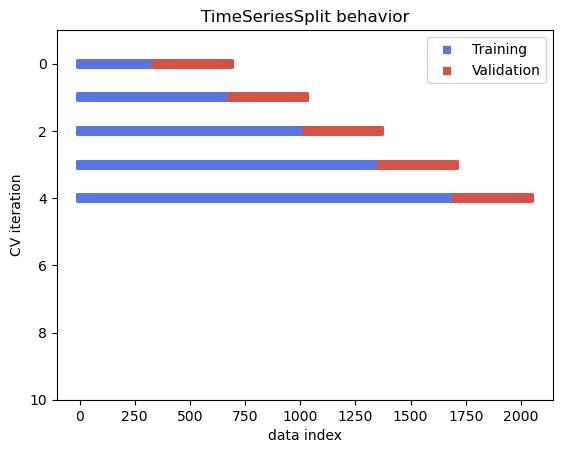

In [5]:
tscv = TimeSeriesSplit()

fig, ax = plt.subplots()
for ii, (train_index, test_index) in enumerate(tscv.split(prices_series)):
    print("LEN OF TRAIN_INDEX:", len(train_index), "LEN OF TEST_INDEX:", len(test_index))
    l1 = ax.scatter(train_index, [ii] * len(train_index), c=[plt.cm.coolwarm(.1)],
                   marker='_', lw=6)
    l2 = ax.scatter(test_index, [ii] * len(test_index), c=[plt.cm.coolwarm(.9)],
                   marker='_', lw=6)
    ax.set(ylim=[10,-1], title='TimeSeriesSplit behavior', xlabel='data index', 
           ylabel='CV iteration')
    ax.legend([l1,l2], ['Training', 'Validation'])

# Modeling

## ARIMA model

First, we do a hyperparameter search over the ARIMA parameters (p,d=1,q) with 5-fold cross-validation. We start by writing a function which computes the mean cross-validation MAPE score for a given choice of p and q.

Note that we set d=1 because we have seen from the Data Wrangling notebook that the stock prices are not a stationary time series, but the first difference (i.e. the returns) is stationary.

In [6]:
def cv_score(p,q):

    scores_list = []

    for ii, (train_index, test_index) in enumerate(tscv.split(prices)):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = ARIMA(prices_series[train], order=(p,1,q))
        results = model.fit()
        prediction = results.predict(test[0],test[-1])
        score = MAPE(prices_series[test], prediction)
        scores_list.append(score)
    
    return sum(scores_list)/len(scores_list)

Then, we scan over a range of values of p and q and print out the mean MAPE score for each of them.

In [7]:
MAPE_score_dict = {}

for p in range(3):
    for q in range(3):
        MAPE_score_dict[cv_score(p,q)] = (p,q)
        print("p = ", p, ", q = ", q, ", mean MAPE score: ", cv_score(p,q))

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p =  0 , q =  0 , mean MAPE score:  0.15526851359151878
p =  0 , q =  1 , mean MAPE score:  0.15521659637740076
p =  0 , q =  2 , mean MAPE score:  0.15529932401295218
p =  1 , q =  0 , mean MAPE score:  0.15520364558445693


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

p =  1 , q =  1 , mean MAPE score:  0.15516422452477444
p =  1 , q =  2 , mean MAPE score:  0.15535232892792078
p =  2 , q =  0 , mean MAPE score:  0.1552569669563942


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

p =  2 , q =  1 , mean MAPE score:  0.15526398061921118


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

p =  2 , q =  2 , mean MAPE score:  0.15173029227914586


We get warnings about failure of Maximum Likelihood Optimization to converge, and also of non-stationary values of the parameters of ARIMA models found. This means that ARIMA models are not very good at fitting the data, but we can still proceed.

In [8]:
#Print the list of MAPE scores, sorted from smallest to largest
sorted_MAPE_scores = sorted(list(MAPE_score_dict.keys()))

In [9]:
#Print out the mallest mean MAPE score:
print(sorted_MAPE_scores[0])

0.15173029227914586


In [10]:
#The value of p and q corresponding to the smallest MAPE score:
print(MAPE_score_dict[sorted_MAPE_scores[0]])

(2, 2)


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


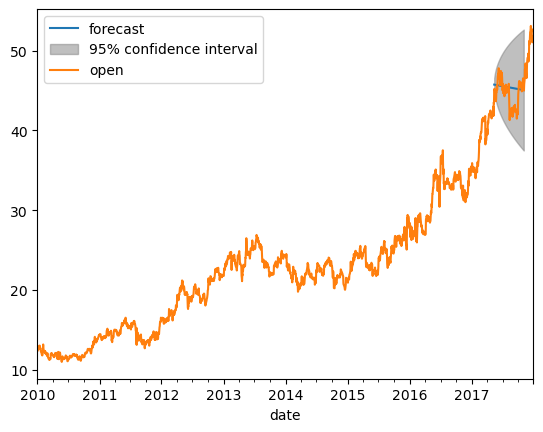

In [11]:
#Choosing p and q to be the best values, and making a plot of the forecast.
fig, ax = plt.subplots()
res = ARIMA(prices_series[:1920], order=(2,0,2)).fit()
plot_predict(res, start=1920, end=2044, ax=ax)
prices.plot(ax=ax)
plt.show()

In [12]:
#Print out a summary of the model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                 1920
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1017.306
Date:                Thu, 01 Jun 2023   AIC                           2046.611
Time:                        10:38:19   BIC                           2079.972
Sample:                    01-01-2010   HQIC                          2058.886
                         - 07-04-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5502     12.053      2.286      0.022       3.927      51.173
ar.L1          0.0182      0.015      1.214      0.225      -0.011       0.048
ar.L2          0.9812      0.015     65.641      0.000       0.952       1.011
ma.L1          0.8334      0.020     42.630      0.000       0.795       0.872
ma.L2         -0.1325      0.013    -10.351      0.000      -0.158      -0.107
sigma2         0.1683      0.002     68.130      0.000       0.163       0.173
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              8509.11
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               4.76   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Exponential smoothing 

Next, we use Simple Exponential Smoothing. We apply cross-validation in the same way as we did for the ARIMA model:

In [13]:
scores_list = []

for ii, (train_index, test_index) in enumerate(tscv.split(prices)):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = SimpleExpSmoothing(prices_series[train])
        results = model.fit()
        prediction = results.predict(test[0],test[-1])
        score = MAPE(prices_series[test], prediction)
        scores_list.append(score)

The mean cross-validation score is:

In [14]:
print(sum(scores_list)/len(scores_list))

0.15523009393135917


In [15]:
#Print a summary of the model
model = SimpleExpSmoothing(prices_series[train])
model.fit().summary()

Dep. Variable:,open,No. Observations:,1704
Model:,SimpleExpSmoothing,SSE,251.103
Optimized:,True,AIC,-3258.936
Trend:,None,BIC,-3248.054
Seasonal:,None,AICC,-3258.912
Seasonal Periods:,None,Date:,"Thu, 01 Jun 2023"
Box-Cox:,False,Time:,10:38:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8685183,alpha,True
initial_level,12.362564,l.0,True


We see that the exponential smoothing model has much lower AIC and BIC compared to the ARIMA model, so the exponential smoothing is better than ARIMA.

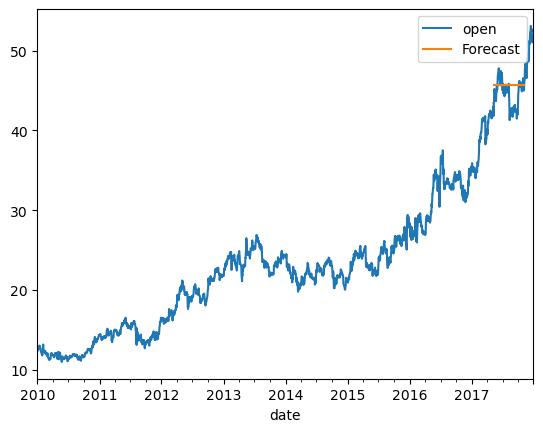

In [16]:
#Choosing p and q to be the best values, and making a plot of the forecast.
fig, ax = plt.subplots()
res = SimpleExpSmoothing(prices_series[:1920]).fit()
predictions = res.predict(start=1920, end=2044)
prices.plot(ax=ax,label='Actual opening prices')
predictions.plot(ax=ax, label='Forecast')
ax.legend()
plt.show()

## Facebook prophet

In [17]:
scores_list = []

for ii, (train_index, test_index) in enumerate(tscv.split(prices)):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = Prophet()
        
        #We have to put the data in the right format to use Prophet: the 'date' column has to be renamed 'ds',
        #and the column containing the time series itself has to be named 'y'
        df = prices_series[train].to_frame().reset_index().rename(columns={"date":"ds","open":"y"})
        df['ds'] = df['ds'].dt.to_timestamp()
        results = model.fit(df)
        future = model.make_future_dataframe(periods=len(test), freq='D')
        prediction = results.predict(future)
        score = MAPE(prices_series[test], prediction[len(train):]['yhat'])
        scores_list.append(score)

10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing
10:38:21 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing
10:38:22 - cmdstanpy - INFO - Chain [1] start processing
10:38:22 - cmdstanpy - INFO - Chain [1] done processing
10:38:23 - cmdstanpy - INFO - Chain [1] start processing
10:38:24 - cmdstanpy - INFO - Chain [1] done processing
10:38:24 - cmdstanpy - INFO - Chain [1] start processing
10:38:25 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
#Print out the mean MAPE score

print(sum(scores_list)/len(scores_list))

0.10459194155739997


10:39:33 - cmdstanpy - INFO - Chain [1] start processing
10:39:33 - cmdstanpy - INFO - Chain [1] done processing


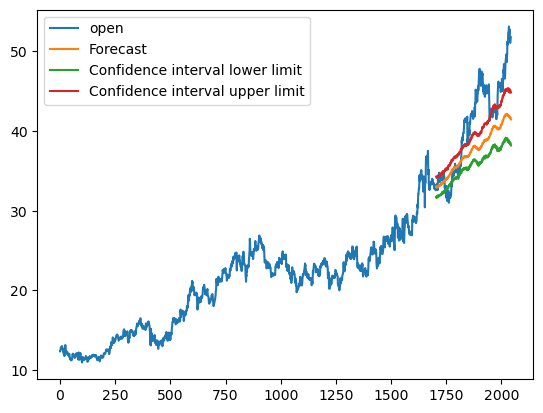

In [21]:
#Choosing p and q to be the best values, and making a plot of the forecast.
fig, ax = plt.subplots()
prophet_model = Prophet()
df = prices_series[train].to_frame().reset_index().rename(columns={"date":"ds","open":"y"})
df['ds'] = df['ds'].dt.to_timestamp()
results = prophet_model.fit(df)
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prediction = results.predict(future)


prices_series.to_frame().reset_index().plot(ax=ax,label='Actual opening prices')
prediction[len(train):]['yhat'].plot(ax=ax, label='Forecast')
prediction[len(train):]['yhat_lower'].plot(ax=ax, label ='Confidence interval lower limit')
prediction[len(train):]['yhat_upper'].plot(ax=ax, label = 'Confidence interval upper limit')

ax.legend()
plt.show()

The Facebook prophet model is the best model.